In [1]:
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import pandas as pd
import os

## Data Loading

In [6]:
path_to_labels = '/Users/katyscott/Desktop/HDFS_Project/Data/Labels'
path_to_features = '/Users/katyscott/Desktop/HDFS_Project/Data/FeatureSelection'
train_test_split = '90_10'

train_liver_labels = pd.read_excel(os.path.join(path_to_labels, ('Liver/HCC_MCRC_ICC_HDFS_liver_'+train_test_split+'_train.xlsx')))
test_liver_labels = pd.read_excel(os.path.join(path_to_labels, ('Liver/HCC_MCRC_ICC_HDFS_liver_'+ train_test_split+ '_test.xlsx')))
liver_features = pd.read_excel(os.path.join(path_to_features, 'HCC_MCRC_ICC_HDFS_liver_notumors_features.xlsx'))
liver_tumor_features = pd.read_excel(os.path.join(path_to_features, 'HCC_MCRC_ICC_HDFS_liver_withtumor_features.xlsx'))

train_tumor_labels = pd.read_excel(os.path.join(path_to_labels, ('Tumor/HCC_MCRC_ICC_HDFS_tumor_'+train_test_split+ '_train.xlsx')))
test_tumor_labels = pd.read_excel(os.path.join(path_to_labels, ('Tumor/HCC_MCRC_ICC_HDFS_tumor_'+ train_test_split+ '_test.xlsx')))
tumor_features = pd.read_excel(os.path.join(path_to_features, 'HCC_MCRC_ICC_HDFS_indextumor_features.xlsx'))

train_liver_feats_and_labels = pd.merge(train_liver_labels, liver_features, how='inner', on=['ScoutID', 'ScoutID'])
test_liver_feats_and_labels = pd.merge(test_liver_labels, liver_features, how='inner', on=['ScoutID', 'ScoutID'])

train_liver_tumor_feats_and_labels = pd.merge(train_liver_labels, liver_tumor_features, how='inner', on=['ScoutID', 'ScoutID'])
test_liver_tumor_feats_and_labels = pd.merge(test_liver_labels, liver_tumor_features, how='inner', on=['ScoutID', 'ScoutID'])

train_tumor_feats_and_labels = pd.merge(train_tumor_labels, tumor_features, how='inner', on=['ScoutID', 'ScoutID'])
test_tumor_feats_and_labels = pd.merge(test_tumor_labels, tumor_features, how = 'inner', on=['ScoutID', 'ScoutID'])


In [9]:

train_liver_feats_and_labels.to_excel(os.path.join(path_to_features, ('HCC_MCRC_ICC_HDFS_'+ train_test_split+'/train_liver_feats_and_labels.xlsx')), index=False)
test_liver_feats_and_labels.to_excel(os.path.join(path_to_features, ('HCC_MCRC_ICC_HDFS_'+ train_test_split+'/test_liver_feats_and_labels.xlsx')), index=False)

train_liver_tumor_feats_and_labels.to_excel(os.path.join(path_to_features, ('HCC_MCRC_ICC_HDFS_'+ train_test_split+'/train_liver_tumor_feats_and_labels.xlsx')), index=False)
test_liver_tumor_feats_and_labels.to_excel(os.path.join(path_to_features, ('HCC_MCRC_ICC_HDFS_'+ train_test_split+'/test_liver_tumor_feats_and_labels.xlsx')), index=False)

train_tumor_feats_and_labels.to_excel(os.path.join(path_to_features, ('HCC_MCRC_ICC_HDFS_'+ train_test_split+'/train_tumor_feats_and_labels.xlsx')), index=False)
test_tumor_feats_and_labels.to_excel(os.path.join(path_to_features, ('HCC_MCRC_ICC_HDFS_'+ train_test_split+'/test_tumor_feats_and_labels.xlsx')), index=False)

# test_tumor_feats_and_labels.to_excel("/media/katy/Data/ICC/HDFS/test_tumor_feats_and_labels.xlsx", index=False)

In [6]:
train_liver_feats_and_labels.columns[4]

'10Percentile'

## Assumptions checking

### Liver

AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

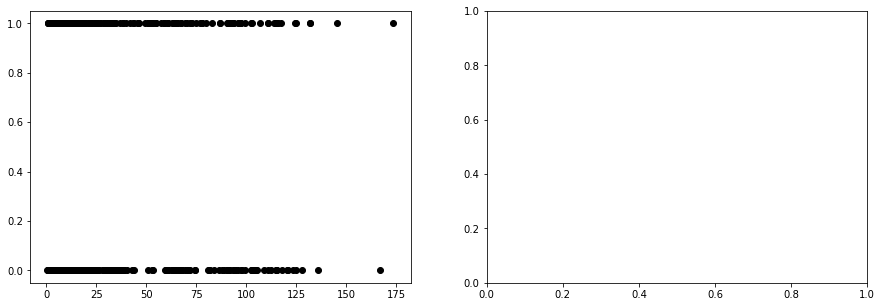

In [15]:
# Start index at 4, first four columns are labels
index = 4
features = list(train_liver_feats_and_labels)
feature = features[index]

# Censoring check
# Binarize the feature around the median for censoring check
train_feature = train_liver_feats_and_labels[feature]
bin_feature = train_feature > train_feature.median()
bin_feature = bin_feature.to_numpy(dtype="float")

high_label = "High " + feature
low_label = "Low " + feature
censor_title = "Censoring pattern for liver " + feature

fig, ax = plt.subplots(1, 2, figsize=(15,5))
censor = plt.subplot(121)

censor.plot(train_liver_labels.HDFS_Time, bin_feature, 'o', color='black')
ax[0].set_title(censor_title)
ax[0].set_xlabel("Time (months)")

# # Kaplan meier checking
# high_feature = train_liver_feats_and_labels.loc[bin_feature == 1]
# low_feature = train_liver_feats_and_labels.loc[bin_feature == 0]
# km = plt.subplot(122)

# kmf = KaplanMeierFitter()
# kmf.fit(high_feature.HDFS_Time, high_feature.HDFS_Code, label=high_label)
# kmf.plot_survival_function(ax=km)

# kmf.fit(low_feature.HDFS_Time, low_feature.HDFS_Code, label=low_label)
# kmf.plot_survival_function(ax=km)

# km_title = "HDFS for liver " + feature + " levels"
# plt.title(km_title)

In [10]:
bin_feature

array([1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1.

### Tumor

Text(0.5, 1.0, 'HDFS for liver Kurtosis levels')

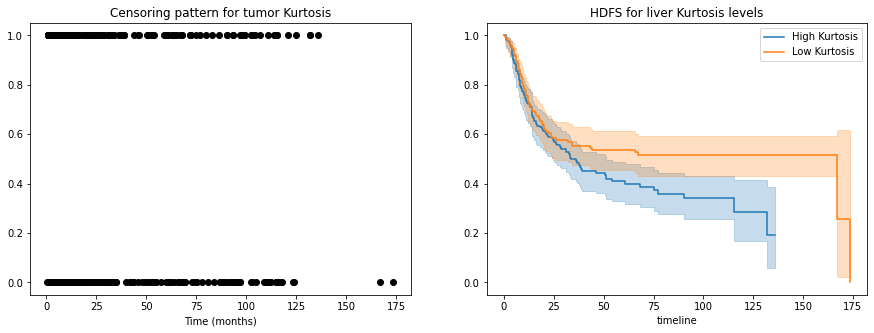

In [9]:
feature = 'Kurtosis'

# Censoring check
# Binarize the feature around the median for censoring check
train_feature = train_tumor_feats_and_labels[feature]
bin_feature = train_feature > train_feature.median()
bin_feature = bin_feature.to_numpy(dtype="float")

high_label = "High " + feature
low_label = "Low " + feature

fig, ax = plt.subplots(1, 2, figsize=(15,5))
censor = plt.subplot(121)
ax[0].set_title("Censoring pattern for tumor " + feature)
ax[0].set_xlabel("Time (months)")

censor.plot(train_tumor_labels.HDFS_Time, bin_feature, 'o', color='black')

# Kaplan meier checking
high_feature = train_tumor_feats_and_labels.loc[bin_feature == 1]
low_feature = train_tumor_feats_and_labels.loc[bin_feature == 0]
km = plt.subplot(122)

kmf = KaplanMeierFitter()
kmf.fit(high_feature.HDFS_Time, high_feature.HDFS_Code, label=high_label)
kmf.plot_survival_function(ax=km)

kmf.fit(low_feature.HDFS_Time, low_feature.HDFS_Code, label=low_label)
kmf.plot_survival_function(ax=km)

title = "HDFS for liver " + feature + " levels"
plt.title(title)

## CoxPH Modelling

In [3]:
liver_feats_for_cph = train_liver_feats_and_labels.drop(labels=["ScoutID", "Cancer_Type"], axis=1)

cph = CoxPHFitter()
cph.fit(liver_feats_for_cph, duration_col='HDFS_Time', event_col='HDFS_Code')
cph.check_assumptions(liver_feats_for_cph, p_value_threshold=0.01, show_plots=True)
cph.print_summary(model='Liver Radiographic Features', decimals=3)

/Users/katyscott/opt/anaconda3/envs/deepicc/lib/python3.8/site-packages/lifelines/utils/__init__.py:1090: ConvergenceWarning: Column(s) ['Coarseness', 'Contrast'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/katyscott/opt/anaconda3/envs/deepicc/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1518: LinAlgWarning: Ill-conditioned matrix (rcond=4.92101e-18): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [17]:
tumor_feats_for_cph = train_tumor_feats_and_labels.drop(labels=["ScoutID", "Cancer_Type", "Mean"], axis=1)

cph = CoxPHFitter()
cph.fit(tumor_feats_for_cph, duration_col='HDFS_Time', event_col='HDFS_Code')
cph.check_assumptions(tumor_feats_for_cph, p_value_threshold=0.01, show_plots=True)
cph.print_summary(model='Tumor Radiographic Features', decimals=3)

Proportional hazard assumption looks okay.


/home/katy/anaconda3/envs/deepicc/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.CoxPHFitter: fitted with 356 total observations, 178 right-censored observations>
             duration col = 'HDFS_Time'
                event col = 'HDFS_Code'
      baseline estimation = breslow
   number of observations = 356
number of events observed = 178
   partial log-likelihood = -943.753
         time fit was run = 2022-02-22 19:25:01 UTC
                    model = Tumor Radiographic Features

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Entropy    0.280      1.323      0.242           -0.194            0.754                0.823                2.126
Variance   0.000      1.000      0.000           -0.000            0.000                1.000                1.000
Skewness   0.018      1.018      0.071           -0.121            0.157                0.886                1.170
Kurtosis   0.000      1.000      0.002           -0.003            0.003                0.997                1.003

              z     p   -log2(p)
covariate                       
Entropy   1.157 0.247      2.015
Variance  0.504 0.614      0.703
Skewness  0.252 0.801      0.319
Kurtosis  0.035 0.972      0.041
---
Concordance = 0.544
Partial AIC = 1895.505
log-likelihood ratio test = 4.358 on 4 df
-log2(p) of ll-ratio test = 1.475